In [ ]:
#!pip install pandas
#!pip install matplotlib
#!pip install numpy
#!pip install librosa

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os

from glob import glob

import librosa
import IPython.display as ipd

## Read Audio Files


In [3]:
audio_files = glob('Desktop/Audio/startup-87026.mp3')
#/Desktop/Audio/startup-87026.mp3


#Playing an audio file using IPython.display
ipd.Audio(audio_files[0])

## Convert to Spectrogram

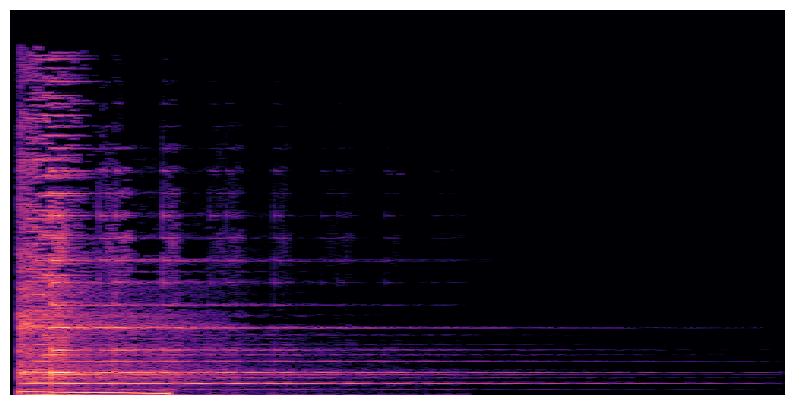

In [11]:
# Function to convert audio to spectrogram
def audio_to_spectrogram(file_path, save_image=True):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Compute Short-Time Fourier Transform (STFT)
    D = librosa.stft(y)

    # Convert amplitude to decibels (log scale)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # Plot the spectrogram without labels
    plt.figure(figsize=(10, 5))
    plt.axis('off')  # Remove axis
    librosa.display.specshow(S_db, sr=sr, x_axis=None, y_axis=None)

    # Save the spectrogram as an image
    if save_image:
        plt.savefig(file_path.replace(".mp3", "_spectrogram.png"), bbox_inches='tight', pad_inches=0)

    # Show the spectrogram
    plt.show()

# Convert the audio file to a spectrogram
for file in audio_files:
    audio_to_spectrogram(file)
